<!-- PELICAN_BEGIN_SUMMARY -->

In this post we're going to do a bunch of cool things following up on the last [post]({filename}/2016-10-19-implicit-mf-part-1.md) introducing implicit matrix factorization. We're going to explore Learning to Rank, a different method for implicit matrix factorization, and then use the library [LightFM](http://lyst.github.io/lightfm/docs/home.html) to incorporate side information into our recommender. Next, we'll use [scikit-optimize](https://scikit-optimize.github.io/) to be smarter than grid search for cross validating hyperparameters. Lastly, we'll see that we can move beyond simple user-to-item and item-to-item recommendations now that we have side information embedded in the same space as our users and items. Let's go!

<!-- PELICAN_END_SUMMARY -->

## History lesson

When I started working at Birchbox, I was tasked with finding a way to incorporate our rich customer information into the implicit feedback matrix factorization recommendation system. I had no idea what I was doing, so I did a lot of google searching. This proved a difficult problem because there are commonly two paradigms of recommender systems - content-based approaches, like when one has demographic customer data and uses this data to find other similar customers, and "ratings-based" approaches, like when one has data on what each user rated each item they interacted with. The desire was for me to marry these two approaches.

Reading through the classic survey article, [Matrix Factorization Techniques for Recommender Systems](http://www.columbia.edu/~jwp2128/Teaching/W4721/papers/ieeecomputer.pdf) (pdf link), revealed a section titled "Additional Input Sources". This contains one such approach to incorporating so-called "side information" into a recommender system. The idea was relatively simple (well, simple relative to the initial hurdle of wrapping one's head around matrix factorization). Let's say that in a regular matrix factorization model, a user $u$ is represented by a single vector $\textbf{x}_{u}$ containing that user's latent factors (see previous posts for more background on this). Now, let's say that we have some demographic information about that user like 

| Feature        | Value           |
|:-------------|:-------------|
| gender      | Female |
| age_bucket      | 25-34      |
| income_bucket | $65-79K      |

We can one-hot-encode each of these features into an "attribute-space" $A$ and assume that each each attribute $a$ has its own latent vector $\textbf{s}_{a}$. Lastly, we make the assumption that our "total" user vector is the original user vector $\textbf{x}_{u}$ plus each of the relevant attribute vectors. If $N(u)$ represents the set of attributes that pertain to user $u$, then the total user vector is

$$\textbf{x}_{u} + \sum\limits_{a \in N(u)}\textbf{s}_{a}$$

One can make the same set of assumptions for side information about the items, and now you can not only achieve better results with your recommendations, but you can also learn vectors and consequently similarities between the side information vectors. For a general overview of this, see a [post](https://making.dia.co/hiring-data-scientists-a-classification-problem-456affe73592#.pk693a7x0) I wrote for Dia&Co's [tech blog](https://making.dia.co/).

Ok, the approach is clear, so presumably we just add this to last post's implicit feedback objective function and solve, right? Well, I ran the math, and unfortunately this is not scalable. With the extra set of side information vectors, last post's Alternating Least Squares (ALS) becomes a three-way alternating problem. There was a special trick in that ALS optimization that exploited the sparsity of the data to scale the computation. Alas, this trick cannot be used during the stage of ALS where one is solving for the side information vectors.

So what to do now?

## Learning to Rank - BPR

It turns out that there is another method of optimizing implicit feedback matrix factorization problems which is neither ALS nor conventional stochastic gradient descent (SGD) on last post's objective function. This method of optimization typically goes by the name [Learning to Rank](https://en.wikipedia.org/wiki/Learning_to_rank) and originated in information retrieval theory.

A classic method of using Learning to Rank with implicit feedback was in the paper [BPR: Bayesian Personalized Ranking from Implicit Feedback](https://arxiv.org/pdf/1205.2618.pdf) (pdf link) first-authored by Steffen Rendle who is kind of a badass in all things implicit and factorized. The idea is centered around sampling *positive* and *negative* items and running pairwise comparisons. Let's assume that for this example our dataset consists of the number of times users have clicked on various items on a website. BPR proceeds as follows (in simplified form):

1. Randomly select a user $u$ and then select a random item $i$ which the user has clicked on. This is our *positive* item.
2. Randomly select an item $j$ which the user has clicked on $fewer$ times than item $i$ (this includes items that they have never clicked). This is our *negative* item.
3. Use whatever equation you want to predict the "score", $p_{ui}$, for user $u$ and positive item $i$. For matrix factorization, this may be $\textbf{x}_{u} \cdot \textbf{y}_{i}$.
4. Predict the score for user $u$ and negative item $j$, $p_{uj}$.
5. Find the difference between the positive and negative scores $x_{uij} = p_{ui} - p_{uj}$.
6. Pass this difference through a sigmoid and use it as a weighting for updating all of the model parameters via stochastic gradient descent (SGD).

This method seemed kind of radical to me when I first read it. Notably, we do not care about the actual value of the score that we are predicting. All we care about is that we rank items which the user has clicked on more frequently higher than items which the user has clicked on fewer times. And thus, our model "learns to rank" :)

Because this model employs a sampling-based approach, the authors show that it can be quite fast and scalable relative to other, slower methods. Additionally, the authors argue that BPR directly optimizes the area under the ROC curve (AUC) which could be a desirable characteristic. Most importantly for me, it allows one to easily add in side information without blowing up the computational speed.

## Learning to Rank - WARP

A close relative of BPR is Weighted Approximate-Rank Pairwise loss (WARP loss) first introduced in [WSABIE: Scaling Up To Large Vocabulary Image Annotation](http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf) by Weston et. al. WARP is quite similar to BPR: you sample a positive and negative item for a user, predict for both, and take the difference. In BPR you then make the SGD update with this difference as a weight. In WARP, you only run the SGD update if you predict *wrong*, i.e. you predict the negative item has a higher score than the positive item. If you do not predict wrong, then you keep drawing negative items until you either get the prediction wrong or reach some cutoff value. 

The authors of the WARP paper claim that this process shifts from optimizing AUC in BPR to optimizing the precision @ k. The seems likely more relevant for most recommender systems, and I usually have better luck optimizing WARP loss over BPR loss. WARP does introduce two hyperparameters, though. One is the margin which determines how wrong your prediction must be to implement the SGD update. In the paper, the margin is 1 meaning you must guess $p_{uj} \gt p_{ui} + 1$ to implement the SGD update. The other hyperparameter is the cutoff which determines how many times you're willing to draw negative samples trying to get a wrong prediction before you give up and move on to the next user.

This sampling approach causes WARP to run quickly when it starts training because you easily get predictions wrong with an untrained model. After training, though, WARP will run slower because it has to sample and predict many items until it gets a wrong prediction and can update. Sounds like a positive problem if it's hard to get your model to predict wrong, though.

## LightFM

Back to my Birchbox story. I originally implemented BPR with side information in pure numpy and scipy. This proved to be quite slow, and around that time the [LightFM](https://github.com/lyst/lightfm) package was open sourced by the people at Lyst. LightFM is written in Cython and is paralellized via HOGWILD SGD. This blew my code out of the water, and I happily switched over to LightFM.

LightFM uses the same method as above to incorporate side information - it assumes that the total "user vector" is the sum of each of the user's relevant side information vectors (which it calls user "features) and treats the items analogously. Above, we assumed that we had two types of latent vectors: $\textbf{x}_{u}$ and $\textbf{s}_{a}$. LightFM treats everything as side information, or features. If we want to have a specific user vector for user $u$, then we must one-hot-encode that as a single feature for that user.

Let's go ahead and install LightFM, read in our good old Sketchfab "likes" data as well as the model tags, and see if we can get better results with LightFM than we did last post using classic ALS.

### Installation

LightFM is on pypi, so you can install simplest with pip:

```bash
pip install lightfm
```

If you are on a mac, then you will unfortunately not be able to run your code in parallel out of the box. If you would like to use parallelization, you must first make sure you have gcc which can be installed with ```brew```:

```bash
brew install gcc --without-multilib
```
Be careful, this takes like 30 minutes. The simplest way I've then found to building LightFM is to trick it. First clone the repository

```bash
git clone git@github.com:lyst/lightfm.git
```

Then, open ```setup.py``` go to where the variable ```use_openmp``` is defined, and hard set it to ```True```. Then, ```cd lightfm && pip install -e .```

With all that done, let's write some code to train some models.

### Data preprocessing

I took a lot of the functions used last time for arranging the Sketchfab data into a matrix and placed them all in a ```helpers.py``` file in the rec-a-sketch repo.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.special import expit
import pickle
import csv
import copy
import itertools
from lightfm import LightFM
import lightfm.evaluation
import sys
sys.path.append('../')
import helpers

In [2]:
df = pd.read_csv('../data/model_likes_anon.psv',
                 sep='|', quoting=csv.QUOTE_MINIMAL,
                 quotechar='\\')
df.drop_duplicates(inplace=True)
df.head()

,modelname,mid,uid
0,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,7ac1b40648fff523d7220a5d07b04d9b
1,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,2b4ad286afe3369d39f1bb7aa2528bc7
2,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,1bf0993ebab175a896ac8003bed91b4b
3,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,6484211de8b9a023a7d9ab1641d22e7c
4,3D fanart Noel From Sora no Method,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,1109ee298494fbd192e27878432c718a


In [3]:
# Threshold data to only include users and models with min 5 likes.
df = helpers.threshold_interactions_df(df, 'uid', 'mid', 5, 5)

Starting interactions info
Number of rows: 62583
Number of cols: 28806
Sparsity: 0.035%
Ending interactions info
Number of rows: 15274
Number of columns: 25655
Sparsity: 0.140%


In [4]:
# Go from dataframe to likes matrix
# Also, build index to ID mappers.
likes, uid_to_idx, idx_to_uid,\
mid_to_idx, idx_to_mid = helpers.df_to_matrix(df, 'uid', 'mid')

likes

<15274x25655 sparse matrix of type '<class 'numpy.float64'>'
	with 547477 stored elements in Compressed Sparse Row format>

In [5]:
train, test, user_index = helpers.train_test_split(likes, 5, fraction=0.2)

The one odd thing that we must do which is different than last time is to copy the training data to only include users with data in the test set. This is due to using LightFM's built-in ```precision_at_k``` function as opposed to our hand-rolled one last time and is not particularly interesting.

In [6]:
eval_train = train.copy()
non_eval_users = list(set(range(train.shape[0])) - set(user_index))

eval_train = eval_train.tolil()
for u in non_eval_users:
    eval_train[u, :] = 0.0
eval_train = eval_train.tocsr()

Now we want to one-hot-encode all of the side information that we have about the Sketchfab models. Recall that this information included categories and tags associated with each model. The simplest way I've found to go about encoding this information is to use scikit-learn's [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) class. The ```DictVectorizer``` takes in a list of dictionaries where the dictionaries contain features names as keys and weights as values. Here, we'll assume that each weight is 1, and we'll take the key to be the combination of the tag type and value.

In [7]:
sideinfo = pd.read_csv('../data/model_feats.psv',
                       sep='|', quoting=csv.QUOTE_MINIMAL,
                       quotechar='\\')
sideinfo.head()

,mid,type,value
0,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,category,Characters
1,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,category,Gaming
2,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,tag,3dsmax
3,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,tag,noel
4,5dcebcfaedbd4e7b8a27bd1ae55f1ac3,tag,loli


In [8]:
# There's probably a fancy pandas groupby way to do
# this but I couldn't figure it out :(

# Build list of dictionaries containing features 
# and weights in same order as idx_to_mid prescribes.
feat_dlist = [{} for _ in idx_to_mid]
for idx, row in sideinfo.iterrows():
    feat_key = '{}_{}'.format(row.type, str(row.value).lower())
    idx = mid_to_idx.get(row.mid)
    if idx is not None:
        feat_dlist[idx][feat_key] = 1

In [9]:
feat_dlist[0]

{'category_characters': 1,
 'category_gaming': 1,
 'tag_3d': 1,
 'tag_3dcellshade': 1,
 'tag_3dsmax': 1,
 'tag_anime': 1,
 'tag_girl': 1,
 'tag_loli': 1,
 'tag_noel': 1,
 'tag_soranomethod': 1}

In [10]:
from sklearn.feature_extraction import DictVectorizer

In [11]:
dv = DictVectorizer()
item_features = dv.fit_transform(feat_dlist)

In [12]:
item_features

<25655x20352 sparse matrix of type '<class 'numpy.float64'>'
	with 161510 stored elements in Compressed Sparse Row format>

We are now left with an ```item_features``` matrix where each row is a unique item (in the same order as the columns of the ```likes``` matrix), and each column is a unique tag. It looks like there are 20352 unique tags!

### Training

Let's try a simple WARP run on LightFM using the default settings and ignoring the item features to start. I am only going to focus on WARP today, as I've never had much luck with BPR. I will create a small function to calculate the learning curve.

In [13]:
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif (isinstance(r, float)
              or isinstance(r, np.float32)
              or isinstance(r, np.float64)):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)

def patk_learning_curve(model, train, test, eval_train,
                        iterarray, user_features=None,
                        item_features=None, k=5,
                        **fit_params):
    old_epoch = 0
    train_patk = []
    test_patk = []
    headers = ['Epoch', 'train p@5', 'test p@5']
    print_log(headers, header=True)
    for epoch in iterarray:
        more = epoch - old_epoch
        model.fit_partial(train, user_features=user_features,
                          item_features=item_features,
                          epochs=more, **fit_params)
        this_test = lightfm.evaluation.precision_at_k(model, test, train_interactions=None, k=k)
        this_train = lightfm.evaluation.precision_at_k(model, eval_train, train_interactions=None, k=k)

        train_patk.append(np.mean(this_train))
        test_patk.append(np.mean(this_test))
        row = [epoch, train_patk[-1], test_patk[-1]]
        print_log(row)
    return model, train_patk, test_patk

In [14]:
model = LightFM(loss='warp', random_state=2016)
# Initialize model.
model.fit(train, epochs=0);

iterarray = range(10, 110, 10)

model, train_patk, test_patk = patk_learning_curve(
    model, train, test, eval_train, iterarray, k=5, **{'num_threads': 4}
)

+------------+------------+------------+
|   Epoch    | train p@5  |  test p@5  |
+============+============+============+
|     10     |  0.14303   |  0.02541   |
+------------+------------+------------+
|     20     |  0.16267   |  0.02947   |
+------------+------------+------------+
|     30     |  0.16876   |  0.03183   |
+------------+------------+------------+
|     40     |  0.17282   |  0.03294   |
+------------+------------+------------+
|     50     |  0.17701   |  0.03333   |
+------------+------------+------------+
|     60     |  0.17872   |  0.03287   |
+------------+------------+------------+
|     70     |  0.17583   |  0.03333   |
+------------+------------+------------+
|     80     |  0.17793   |  0.03386   |
+------------+------------+------------+
|     90     |  0.17479   |  0.03392   |
+------------+------------+------------+
|    100     |  0.17656   |  0.03301   |
+------------+------------+------------+


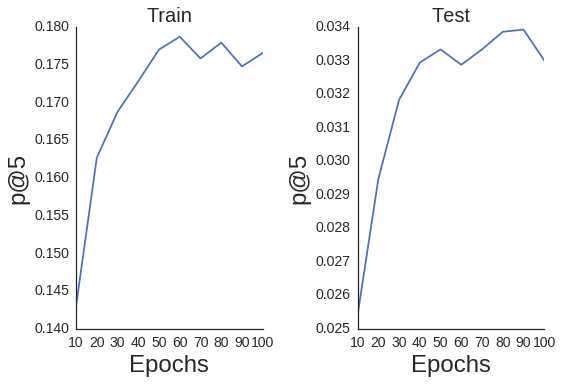

In [15]:
import seaborn as sns
sns.set_style('white')

def plot_patk(iterarray, patk,
              title, k=5):
    plt.plot(iterarray, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('p@{}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

# Plot train on left
ax = plt.subplot(1, 2, 1)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, train_patk,
         'Train', k=5)

# Plot test on right
ax = plt.subplot(1, 2, 2)
fig = ax.get_figure();
sns.despine(fig);
plot_patk(iterarray, test_patk,
         'Test', k=5)

plt.tight_layout();

## Optimizing Hyperparameters with ```scikit-optimize```

Now that we have a baseline, we would like to find optimal hyperparameters to maximize our p@k. On a side note, I'm not sure if precision at k is the best metric to be using here when all of our interactions are binary, but let's just ignore that for now...

Last post I ran a grid search over a bunch of hyperparameters, and it took forever. It's been shown that a randomized search is better than explicit grid search, but we can do even better. Using the [scikit-optimize](https://scikit-optimize.github.io/) (```skopt```) library, we can treat the hyperpameters as free parameters to search over while using a black box optimization algorithm to maximize p@k. There are a number of optimization algorithms to pick from, but I'll just stick with ```forest_minimize``` today.

The setup is pretty simple. You must first define an objective function that you want to minimize. The objective receives the parameters that you want to solve for as the arguments and returns the objective value at those parameters. Thus, for our case, we pass in the hyperparameters, we train the ```LightFM``` model with those parameters, and then return the p@k evaluated after training. Importantly, we must return the negative of the p@k because the objective must be *minimized*, so maximizing p@k is the same as minimizing the negative of the p@k. The last thing to note is that one must make liberal use of global variables because one can only pass hyperparameters to the objective function.

In [16]:
from skopt import forest_minimize

In [17]:
def objective(params):
    # unpack
    epochs, learning_rate,\
    no_components, alpha = params
    
    user_alpha = alpha
    item_alpha = alpha
    model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
              num_threads=4, verbose=True)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                              train_interactions=None,
                                              k=5, num_threads=4)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Handle some weird numerical shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

With the objective function defined, we can define ranges for our hyperparameters. These can either be simple max and mins or we can assume a distribution like below. With the ranges defined, we simple call ```forest_minimize``` and wait a pretty long time.

In [18]:
space = [(1, 260), # epochs
         (10**-4, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-6, 10**-1, 'log-uniform'), # alpha
        ]

res_fm = forest_minimize(objective, space, n_calls=250,
                     random_state=0,
                     verbose=True)

In [19]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'alpha']
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))

Maximimum p@k found: 0.04781
Optimal parameters:
epochs: 168
learning_rate: 0.09126423099690231
no_components: 104
alpha: 0.00023540795300720628


No too shabby! We started with a p@k of ~0.034 with base hyperparameters, and then increased it to 0.0478 by finding better ones. Let's see what happens if we add in our item features as side information to the matrix factorization model.

## Learning to Rank + Side Information

```LightFM``` makes certain subtle assumptions when you do or do not pass side information. When no ```user_features``` or ```item_features``` are explicitly included, then ```LightFM``` assumes that both feature matrices are in fact identity matrices of size (```num_users``` X ```num_users```) or (```num_items``` X ```num_items```) for user and item feature matrices, respectively. What this is effectively doing is one-hot-encoding each user and item ID as a single feature vector. In the case where you do pass an ```item_features``` matrix, then ```LightFM``` does not do any one-hot-encoding. Thus, each user and item ID does not get its own vector unless you explicitly define one. The easiest way to do this is to make your own identity matrix and stack it on the side of the ```item_features``` matrix that we already created. This way, each item is described by a single vector for its unique ID and then a set of vectors for each of its tags.

In [20]:
# Need to hstack item_features
eye = sp.eye(item_features.shape[0], item_features.shape[0]).tocsr()
item_features_concat = sp.hstack((eye, item_features))
item_features_concat = item_features_concat.tocsr().astype(np.float32)

We now need to define a new objective function that incorporates the ```item_features```.

In [21]:
def objective_wsideinfo(params):
    # unpack
    epochs, learning_rate,\
    no_components, item_alpha,\
    scale = params
    
    user_alpha = item_alpha * scale
    model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(train, epochs=epochs,
              item_features=item_features_concat,
              num_threads=4, verbose=True)
    
    patks = lightfm.evaluation.precision_at_k(model, test,
                                              item_features=item_features_concat,
                                              train_interactions=None,
                                              k=5, num_threads=3)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Weird shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

With that defined, let's now run a new hyperparameter search. I will add an extra scaling parameter which will control the scaling between the user and item item regularization (alpha) terms. Because of all of the extra item features, we may want to regularize things differently. We'll also input an ```x0``` term to ```forest_minimization``` which will allow us to start our hyperparameter search at the optimal parameters from the previous run without side information. 

In [22]:
space = [(1, 260), # epochs
         (10**-3, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-5, 10**-3, 'log-uniform'), # item_alpha
         (0.001, 1., 'log-uniform') # user_scaling
        ]
x0 = res_fm.x.append(1.)
# This typecast is required
item_features = item_features.astype(np.float32)
res_fm_itemfeat = forest_minimize(objective_wsideinfo, space, n_calls=50,
                                  x0=x0,
                                  random_state=0,
                                  verbose=True)

In [23]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm_itemfeat.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'item_alpha', 'scaling']
for (p, x_) in zip(params, res_fm_itemfeat.x):
    print('{}: {}'.format(p, x_))

Maximimum p@k found: 0.04610
Optimal parameters:
epochs: 192
learning_rate: 0.06676184785227865
no_components: 86
item_alpha: 0.0005563892936299544
scaling: 0.6960826359109953


Now, you might be thinking "Ethan, we went through all that only to get *worse* p@k?!", and, frankly, I share your frustration. I've actually seen this happen before - adding side information will sometimes reduce or at least not increase whatever metric you're looking for. In all fairness, I only ran the above optimization for 50 calls, as opposed to the original one with 250 calls. This was mainly due to the matrix factorization model running much slower due to scaling with the number of user and item features. 

Even so, there are other reasons that the results could be worse. Maybe user behavior is a much better signal than human-defined tags and categories. The tag information could be poor for some of the models. As well, one may need to scale the tags *differently* compared to the unique ID vectors using, say, separate regularization terms, in order to get better behavior. Maybe one should normalize the tag weights by the number of tags. Maybe tags should not be included unless they have been used on at least ```X``` models. Maybe tags should only be included on models with few user interactions because after that ponit the cold start problem is sufficiently null. Who knows?! These are experiments I'd love to run, but I'd be happy to hear from others' experience.

## Fun with Feature Embeddings

Regardless of all of this, there is still a benefit to incorporating the item features. Because they have vectors embedded in the same space as the users and items, we can play with different types of recommendations. We'll first retrain the model on the full dataset using the optimal parameters.

In [24]:
epochs, learning_rate,\
no_components, item_alpha,\
scale = res_fm_itemfeat.x

user_alpha = item_alpha * scale
model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=learning_rate,
                no_components=no_components,
                user_alpha=user_alpha,
                item_alpha=item_alpha)
model.fit(likes, epochs=epochs,
          item_features=item_features_concat,
          num_threads=4)

### Feature Sorting

Imagine you're on Sketchfab and click the tag [tiltbrush](https://sketchfab.com/tags/tiltbrush) which would presumably correspond to models created with Google's [Tilt Brush](https://www.tiltbrush.com/) VR appliction. How should Sketchfab return the results to you? They currently return results based on the popularity of the items which is presumably not connected to the "tiltbrushiness" of the models. With the factorized tags, we can now return a list of products that are *most similar* to the tiltbrush tag sorted by that similarity. To do this, we must find the tiltbrush vector and measure the cosine similarity to every product.

Recall that we tacked our identity matrix onto the left-hand side of the item_features matrix. This means that our ```DictVectorizer```, which mapped our item features to column indices of our ```item_features``` matrix, will have indices that are off by the number of items.

In [25]:
idx = dv.vocabulary_['tag_tiltbrush'] + item_features.shape[0]

Next, we need to calculate the cosine similarity between the tiltbrush vector and all other item *representations* where each item's representation is the sum of its feature vectors. These feature vectors are stored as ```item_embeddings``` in the LightFM model. (*Note: there are technically bias terms in the LightFM model that we are simply ignoring for now*).

In [26]:
def cosine_similarity(vec, mat):
    sim = vec.dot(mat.T)
    matnorm = np.linalg.norm(mat, axis=1)
    vecnorm = np.linalg.norm(vec)
    return np.squeeze(sim / matnorm / vecnorm)

tilt_vec = model.item_embeddings[[idx], :]
item_representations = item_features_concat.dot(model.item_embeddings)
sims = cosine_similarity(tilt_vec, item_representations)

Lastly, we can repurpose some code from the last blog post to visualize the top 5 Sketchfab model thumbnails that are most similar to the tiltbrush vector.

In [27]:
import requests
def get_thumbnails(row, idx_to_mid, N=10):
    thumbs = []
    mids = []
    for x in np.argsort(-row)[:N]:
        response = requests.get('https://sketchfab.com/i/models/{}'\
                                .format(idx_to_mid[x])).json()
        thumb = [x['url'] for x in response['thumbnails']['images']
                 if x['width'] == 200 and x['height']==200]
        if not thumb:
            print('no thumbnail')
        else:
            thumb = thumb[0]
        thumbs.append(thumb)
        mids.append(idx_to_mid[x])
    return thumbs, mids

In [28]:
from IPython.display import display, HTML

def display_thumbs(thumbs, mids, N=5):
    thumb_html = "<a href='{}' target='_blank'>\
                  <img style='width: 160px; margin: 0px; \
                  float: left; border: 1px solid black;' \
                  src='{}' /></a>"
    images = ''
    for url, mid in zip(thumbs[0:N], mids[0:N]):
        link = 'http://sketchfab.com/models/{}'.format(mid)
        images += thumb_html.format(link, url)
    display(HTML(images))

In [29]:
display_thumbs(*get_thumbnails(sims, idx_to_mid))

Pretty cool! Looks like each of these are made with Tiltbrush. Feel free to click the above images to check out each model on the Sketchfab website.

What else can we do?

### Tag Suggestions

Let's say that Sketchfab would like to encourage people to use more tags. This is advantageous to the company because it get users to create structured data for them for free while engaging the user. Sketchfab could encourage this behavior by suggesting tags to go with an image. One way we could do this would be to take a model and suggest tags to go with it that are not currently there. This involves finding tag vectors that are most similar to the model and then filtering tags that are already present.

In [30]:
idx = 900
mid = idx_to_mid[idx]
def display_single(mid):
    """Display thumbnail for a single model"""
    response = requests.get('https://sketchfab.com/i/models/{}'\
                            .format(mid)).json()
    thumb = [x['url'] for x in response['thumbnails']['images']
             if x['width'] == 200 and x['height']==200][0]
    thumb_html = "<a href='{}' target='_blank'>\
                  <img style='width: 200px; margin: 0px; \
                  float: left; border: 1px solid black;' \
                  src='{}' /></a>"
    link = 'http://sketchfab.com/models/{}'.format(mid)
    display(HTML(thumb_html.format(link, thumb)))

display_single(mid)

# Make mapper to map from from feature index to feature name
idx_to_feat = {v: k for (k, v) in dv.vocabulary_.items()}
print('Tags:')
for i in item_features.getrow(idx).indices:
    print('- {}'.format(idx_to_feat[i]))

Tags:
- category_architecture
- category_characters
- category_cultural heritage
- category_products & technology
- category_science, nature & education
- tag_rock
- tag_sculpture
- tag_woman


In [31]:
# Indices of all tag vectors
tag_indices = set(v for (k, v) in dv.vocabulary_.items()
                  if k.startswith('tag_'))
# Tags that are already present
filter_tags = set(i for i in item_features.getrow(idx).indices)

item_representation = item_features_concat[idx, :].dot(model.item_embeddings)
sims = cosine_similarity(item_representation, model.item_embeddings)

suggested_tags = []
i = 0
recs = np.argsort(-sims)
n_items = item_features.shape[0]
while len(suggested_tags) < 10:
    offset_idx = recs[i] - n_items
    if offset_idx in tag_indices\
       and offset_idx not in filter_tags:
        suggested_tags.append(idx_to_feat[offset_idx])
    i += 1
print('Suggested Tags:')
for t in suggested_tags:
    print('- {}'.format(t))

Suggested Tags:
- tag_greek
- tag_castel
- tag_santangelo
- tag_eros
- tag_humanti
- tag_galleria
- tag_batholith
- tag_rome
- tag_substanced880
- tag_roman


## Quick conclusion

So this post was long. There was a lot to learn and a lot of parameters to optimize. I'd like to note that, in terms of out of the box performance, it's hard to beat the ALS model from last post. There's fewer parameters to optimize, and the model is much more "forgiving" of being a bit off in your hyperparameters. Contrastingly, if your learning rate is poor, then SGD will give you *nothing* in return. It is definitely possible to beat ALS in performance, though, if you spend enough time fiddling around. Moreover, the ability to incorporate side information is important for being able to make new types of recommendations and overcome the cold start problem, so it's good to have this in your toolbox.